# Graph Neural Networks in Python
- revised from Daniel Holmberg's [An introduction and step-by-step implementation, 2022/02/19](https://towardsdatascience.com/graph-neural-networks-in-python-c310c7c18c83), it colab - [gnn_python.ipynb](https://colab.research.google.com/drive/17eRoYIBxlgxAMKHV4qmXmBYL2-Wkl3Xx?usp=sharing#scrollTo=da0bjc6qrGTH)

## What is a Graph

In [1]:
import networkx as nx

In [2]:
H = nx.DiGraph()
print(H.is_directed())

True


In [3]:
# Add multiple nodes with attributes
H.add_nodes_from([
  (0, {"color": "gray", "size": 450}),
  (1, {"color": "yellow", "size": 700}),
  (2, {"color": "red", "size": 250}),
  (3, {"color": "pink", "size": 500})
])

In [4]:
for node in H.nodes(data=True):
  print(node)

(0, {'color': 'gray', 'size': 450})
(1, {'color': 'yellow', 'size': 700})
(2, {'color': 'red', 'size': 250})
(3, {'color': 'pink', 'size': 500})


In [5]:
H.add_edges_from([
  (0, 1),
  (1, 2),
  (2, 0),
  (2, 3),
  (3, 2)
])

In [6]:
print(H.edges())

[(0, 1), (1, 2), (2, 0), (2, 3), (3, 2)]


In [7]:
def print_graph_info(G):
  print("Directed graph:", G.is_directed())
  print("Number of nodes:", G.number_of_nodes())
  print("Number of edges:", G.number_of_edges())

In [8]:
print_graph_info(H)

Directed graph: True
Number of nodes: 4
Number of edges: 5


It can also be very helpful to plot a graph that you are working with. This can be achieved using *nx.draw*. We use the nodes’ features to color each node and give each of them their own size in the plot. 
- Since node attributes come as dictionaries, and the draw function only accepts lists we will have to convert them first. 
- The resulting graph looks like it is supposed to with 4 nodes, 5 edges and the correct node features.

In [9]:
node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

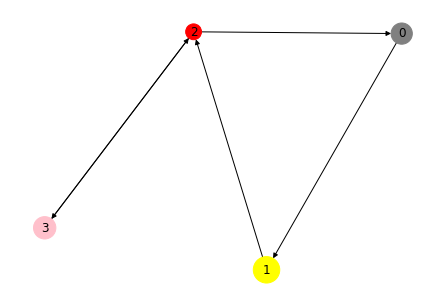

In [10]:
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

In [11]:
G = H.to_undirected()
print_graph_info(G)

Directed graph: False
Number of nodes: 4
Number of edges: 4


In [12]:
print(G.edges())

[(0, 1), (0, 2), (1, 2), (2, 3)]


The number of edges has curiously decreased by one. If we take a closer look we can see that the edge (3, 2) has disappeared, which is reasonable since an undirected edge can be represented by only one tuple, in this case (2, 3).

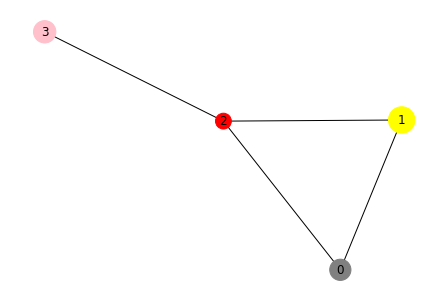

In [13]:
nx.draw(G, with_labels=True, node_color=colors, node_size=sizes)

In [14]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.10.0+cu111


## The Karate Club Network

In [45]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
!pip install torch-geometric

!pip install torchviz

Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html


[KarateClub Dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub)

The Karate Club dataset is available through PyTorch Geometric (PyG ) [3]. The PyG library contains all sorts of methods for deep learning on graphs and other irregular structures. We begin by inspecting some of the properties of the dataset. It seems to only contain one graph, which is expected since it depicts one club. Furthermore, each node in the dataset is assigned a 34 dimensional feature vector that uniquely represents every node. Every member of the club is part of one of 4 factions, or classes in machine learning terms.

In [16]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)

Dataset: KarateClub()
# Graphs: 1
# Features: 34
# Classes: 4


- We see that the graph is undirected, and it has 34 nodes, each with 34 features as mentioned before. 
- The edges are represented as tuples, and there are 156 of them. However, in PyG undirected edges are represented as two tuples, one for each direction, also known as bi-diretional, meaning that there are 78 unique edges in the Karate Club graph. 
- PyG only include entries in A which are non-zero, which is why edges are represented like this. This type of representation is known as **coordinate format**, which is commonly used for sparse matrices. 
- ***label***: Each node has a ***label***, ***y***, that holds information about which class the corresponding node is part of. 
- ***train_mask***: The data also contains a ***train_mask*** that has the indices of the nodes we know the ground truth labels for during training. 
- There are 4 truth nodes, one for each faction, and the task at hand is then to infer the faction for the rest of the nodes.

In [17]:
data = dataset[0]
print(data)
print("Training nodes:", data.train_mask.sum().item(), "/", data.num_nodes)
print("Is directed:", data.is_directed())

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Training nodes: 4 / 34
Is directed: False


In [18]:
data.x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

We convert the Karate Club Network to a Networkx graph, which allows us to use the ***nx.draw*** function to visualize it. The nodes are colored according to the class (or faction) they belong to.

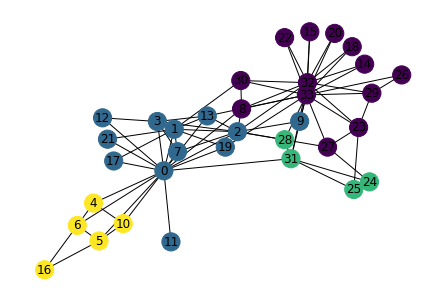

In [40]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=True, node_color=data.y, node_size=330)

## Semi-supervised node classification

When training a model to perform node classification it can be referred to as **semi-supervised machine learning**, which is the general term used for models that combine labeled and unlabeled data during training. 

In the case of node classification we have access to all the nodes in the graph, even those belonging to the test set. The only information missing is the labels of the test nodes.

**Graph Convolutional Networks (GCNs)** will be used to classify nodes in the test set. 
1.  A layer in a graph neural network can be written as a non-linear function **$f$**:
$$H^{(l+1)} = \left( H^{(l)}, A \right)$$
that take as inputs the graph’s **adjacency matrix** ***$A$*** and **(latent) node features** ***$H$*** for some layer ***$l$***
2. A simple** layer-wise propagation rule** for a graph neural network would look something like this:
$$f \left( H^{(l)}, A \right) = \sigma \left( AH^{(l)} W^{(l)} \right)$$
where ***$W$*** is a weight matrix for the ***$l$***-th neural network layer, and ***$\sigma$*** is a non-linear activation function. 
  - Multiplying the weights with the adjacency matrix means that all the feature vectors of all (1-hop) neighboring nodes are summed and aggregated for every node. However, the feature vector of the node itself is not included.
3. To address this, Kipf and Welling [[4]](https://arxiv.org/abs/1609.02907) add the identity matrix to the adjacency matrix and denote this new matrix $\hat{A} = A + I$. 
  - Multiplication of the adjacency matrix will also change the scale of the feature vectors. To counteract this, **$\hat{A}$** is **multiplied by its diagonal degree matrix symmetrically**, yielding the final GCN propagation rule:
  $$f \left( H^{(l)}, A \right) = \sigma \left( \hat{D}^{- {1\over 2}} \hat{A} \hat{D}^{- {1\over 2}}H^{(l)} W^{(l)} \right)$$

The **GCN** layer is already a part of what PyG, and it can be readily be imported as the **GCNConv** class. The same way layers can be stacked in normal neural networks, it is also possible to stack multiple GCN layers. 
* Having a 3-layer GCN will result in three successive propagation steps, leading to every node being updated with information from 3 hops away. 

The first layer of the model must have as many input units as the number of features every node has. 
* In line with the original GCN paper the latent dimensions are set to 4, apart from the last one, which is set to 2. This allows us to plot the learned latent embedding as a two dimensional scatter plot later on, to see if the model manages to learn embeddings that are similar for nodes belonging to the same class. 
* The hyperbolic tangent activation function is used in-between GCN layers as a non-linearity. The output layer maps the 2 dimensional node embedding to 1 out of the 4 classes.

In [22]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(dataset.num_features, 4)
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 2)
    self.classifier = Linear(2, dataset.num_classes)

  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()
    out = self.classifier(h)
    return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [44]:
!pip install torchviz
from torchviz import make_dot

#make_dot(yhat, params=dict(list(model.named_parameters()))).render("gcn_torchviz", format="png")

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=8ed58d2aa78742f624ff359d8251f8675bc5c3746229ecbf1c77b53f9eb94d21
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [23]:
out, h = model(data.x, data.edge_index)
print("Embedding shape:", h.shape)

Embedding shape: torch.Size([34, 2])


In [24]:
import matplotlib.pyplot as plt

def plot_embedding(h, color=data.y, size=100):
  h = h.detach().numpy()
  fig = plt.figure(figsize=(6, 6))
  plt.scatter(h[:, 0], h[:, 1], c=color, s=size)
  plt.show()

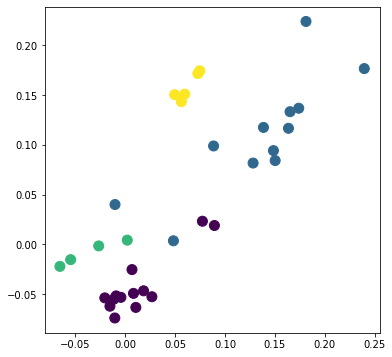

In [25]:
plot_embedding(h)

1.  **cross-entropy** as loss functions since it is well suited for multi-class classification problems
2.  initialize **Adam** as a stochastic gradient optimizer. 
3.  We create a standard PyTorch training loop, and let it run for 300 epochs. 
  - Note that while all nodes do indeed get updates to their node embeddings, the loss is only calculated for nodes in the training set. 
4. The loss is drastically decreased during training, meaning that the classification works well. 
5. The 2 dimensional embeddings from the last GCN layer are stored as a list so that we can animate the evolution of the embeddings during training, giving some insight into the latent space of the model.

In [26]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
def train(data):
  optimizer.zero_grad()
  out, h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, h

In [28]:
embeddings = []
losses = []
epochs = range(1, 301)

for epoch in epochs:
  loss, h = train(data)
  losses.append(loss)
  embeddings.append(h)
  print(f"Epoch: {epoch}\tLoss: {loss:4f}")

Epoch: 1	Loss: 1.399590
Epoch: 2	Loss: 1.374863
Epoch: 3	Loss: 1.354475
Epoch: 4	Loss: 1.338001
Epoch: 5	Loss: 1.324809
Epoch: 6	Loss: 1.313724
Epoch: 7	Loss: 1.303437
Epoch: 8	Loss: 1.292890
Epoch: 9	Loss: 1.281439
Epoch: 10	Loss: 1.268867
Epoch: 11	Loss: 1.255290
Epoch: 12	Loss: 1.241012
Epoch: 13	Loss: 1.226382
Epoch: 14	Loss: 1.211694
Epoch: 15	Loss: 1.197118
Epoch: 16	Loss: 1.182660
Epoch: 17	Loss: 1.168174
Epoch: 18	Loss: 1.153420
Epoch: 19	Loss: 1.138178
Epoch: 20	Loss: 1.122354
Epoch: 21	Loss: 1.106041
Epoch: 22	Loss: 1.089498
Epoch: 23	Loss: 1.073041
Epoch: 24	Loss: 1.056910
Epoch: 25	Loss: 1.041195
Epoch: 26	Loss: 1.025855
Epoch: 27	Loss: 1.010805
Epoch: 28	Loss: 0.996023
Epoch: 29	Loss: 0.981596
Epoch: 30	Loss: 0.967692
Epoch: 31	Loss: 0.954475
Epoch: 32	Loss: 0.942010
Epoch: 33	Loss: 0.930215
Epoch: 34	Loss: 0.918932
Epoch: 35	Loss: 0.908049
Epoch: 36	Loss: 0.897575
Epoch: 37	Loss: 0.887581
Epoch: 38	Loss: 0.878084
Epoch: 39	Loss: 0.868989
Epoch: 40	Loss: 0.860145
Epoch: 41

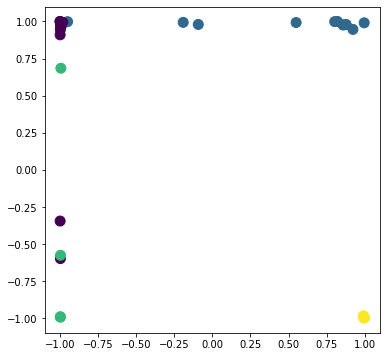

In [29]:
plot_embedding(h)

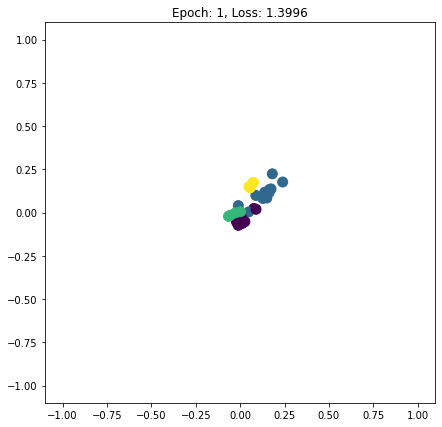

In [30]:
import matplotlib.animation as animation

def animate(i):
    ax.clear()
    h = embeddings[i]
    h = h.detach().numpy()
    ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
    ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

fig = plt.figure(figsize=(7, 7))
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=len(epochs))
plt.show()

In [31]:
from IPython import display

video = anim.to_html5_video()
html_code = display.HTML(video)
display.display(html_code)

In [32]:
gif_writer = animation.PillowWriter(fps=20)
anim.save('embeddings.gif', writer=gif_writer)